# Inception V4 Pretrained Model (timm)

`timm` 라이브러리를 사용하여 ImageNet으로 pretrain된 순수 Inception V4 모델을 불러와서 운전자 행동 분류를 수행합니다.

# Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import KFold

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

사용 디바이스: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Data Load

In [2]:
# 데이터 경로
base_dir = r'c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj'
driver_csv_path = os.path.join(base_dir, 'data', 'driver_imgs_list.csv')
train_dir = os.path.join(base_dir, 'data', 'imgs', 'train')
test_dir = os.path.join(base_dir, 'data', 'imgs', 'test')

# 하이퍼파라미터
img_size = 299  # Inception V4 입력 크기
batch_size = 32
num_classes = 10
num_epochs = 50
learning_rate = 0.001
num_workers = 0

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print(f"이미지 크기: {img_size}x{img_size}")
print(f"배치 크기: {batch_size}")

Train directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\train
Test directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\test
이미지 크기: 299x299
배치 크기: 32


고유 운전자 수: 26명
운전자 목록: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


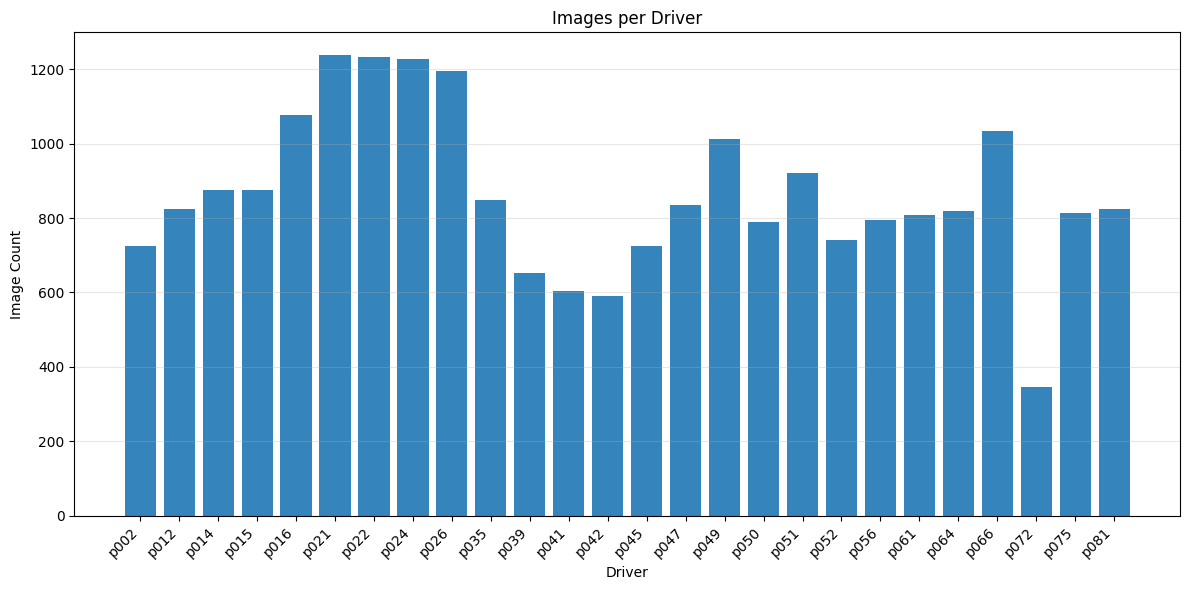

In [3]:
driver_df = pd.read_csv(driver_csv_path)

print(f"고유 운전자 수: {driver_df['subject'].nunique()}명")
print(f"운전자 목록: {sorted(driver_df['subject'].unique())}")

driver_counts = driver_df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(driver_counts.index.astype(str), driver_counts.values, color='C0', alpha=0.9)
plt.xlabel('Driver')
plt.ylabel('Image Count')
plt.title('Images per Driver')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5-Fold Cross Validation
fold별 운전자 목록을 미리 나누긴 하되 초기 실험 단계에서는 한 폴드(fold 2, 학습 데이터가 가장 많아서..)만 사용하고 이후 마무리 단계에서 전체 폴드 다 돌려서 일반화 성능 끌어올리는 방향으로 진행.

## split train data into 5 folds

In [4]:
all_drivers = sorted(driver_df['subject'].unique())

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_splits = []
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(all_drivers)):
	train_drivers = [all_drivers[i] for i in train_indices]
	val_drivers = [all_drivers[i] for i in val_indices]

	fold_splits.append({
		'fold': fold_idx+1,
		'train_drivers': train_drivers,
		'val_drivers': val_drivers
	})

	print("Fold", fold_idx+1)
	print("train:", train_drivers, "val:", val_drivers)
	
	train_imgs = driver_df[driver_df['subject'].isin(train_drivers)]
	val_imgs = driver_df[driver_df['subject'].isin(val_drivers)]
	print(f"학습 이미지: {len(train_imgs)}개")
	print(f"검증 이미지: {len(val_imgs)}개")

Fold 1
train: ['p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p039', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p081'] val: ['p002', 'p026', 'p035', 'p041', 'p050', 'p075']
학습 이미지: 17446개
검증 이미지: 4978개
Fold 2
train: ['p002', 'p015', 'p016', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p075', 'p081'] val: ['p012', 'p014', 'p021', 'p045', 'p072']
학습 이미지: 18418개
검증 이미지: 4006개
Fold 3
train: ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p050', 'p051', 'p052', 'p056', 'p061', 'p066', 'p072', 'p075', 'p081'] val: ['p015', 'p016', 'p042', 'p049', 'p064']
학습 이미지: 18049개
검증 이미지: 4375개
Fold 4
train: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p056', 'p064', 'p072', 'p075'] val: ['p051', 'p052', 'p061', 'p066', 'p081

## define DraiverDataset

In [13]:
driver_df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [14]:
class DriverDataset(Dataset):
    """운전자 행동 데이터셋"""
    
    def __init__(self, data_dir, driver_df, driver_list, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []
        
        if is_test:
            test_images_dir = os.path.join(data_dir, 'test')
            for img_name in os.listdir(test_images_dir):
                self.images.append(os.path.join(test_images_dir, img_name))
        else: #is_train
            driver_subset = driver_df[driver_df['subject'].isin(driver_list)]

            for _, row in driver_subset.iterrows():
                class_name = row['classname']
                img_name = row['img']
                img_path = os.path.join(data_dir, class_name, img_name)

                self.images.append(img_path)
                class_idx = int(class_name[1:])
                self.labels.append(class_idx)
        print(f"{'테스트' if is_test else '운전자' + str(len(driver_list))+'명'}, 데이터 {len(self.images)}개 이미지")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, os.path.basename(img_path)
        else:
            label = self.labels[idx]
            return image, label

## define team transform

In [6]:
team_transform_train = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.RandomRotation(degrees=15),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),

	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

team_transform_eval = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

## train

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에폭(Epoch) 동안 모델을 학습시키고 손실과 정확도를 반환합니다.
    """
    model.train()  # 모델을 학습 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 훈련 데이터셋의 모든 배치를 반복합니다.
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # 순전파 (Forward pass)
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
        
        # 역전파 및 최적화 (Backward pass and optimization)
        loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    return epoch_loss, epoch_acc.item()

In [8]:
def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋을 이용해 모델의 성능(손실과 정확도)을 평가하고 반환합니다.
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 그래디언트 계산을 비활성화합니다.
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
            
            # 통계 업데이트
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    # epoch_loss가 Log Loss에 해당하며, 이 값을 기준으로 최고 성능 모델을 저장합니다.
    return epoch_loss, epoch_acc.item()

In [16]:
def train_fold(fold_idx, train_drivers, val_drivers):
    """한 폴드 학습 (Log Loss 기준)"""

    print(f"\n========== Fold {fold_idx}/{n_folds} ==========")

    train_dataset = DriverDataset(
        train_dir, driver_df, train_drivers,
        transform=team_transform_train, is_test=False
    )

    val_dataset = DriverDataset(
        train_dir, driver_df, val_drivers,
        transform=team_transform_eval, is_test=False
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    print(f"학습 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    model = timm.create_model(
        'inception_v4',
        pretrained=True,
        num_classes = num_classes
    )
    model = model.to(device)

    # Log Loss 사용을 위해 criterion은 그대로 CrossEntropyLoss를 사용합니다.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)
    
    # mode='min'으로 설정하여 Log Loss 최소화를 목표로 합니다.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # 최고 검증 손실 추적
    best_val_loss = float('inf') 
    best_model_path = f'best_inception_v4_fold{fold_idx}.pth'

    # 에폭 학습
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 70)
        
        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증 (val_loss가 Log Loss에 해당)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 결과 출력
        print(f'\n📊 Epoch {epoch+1} 결과:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # 검증 손실을 기준으로 스케줄러 step
        scheduler.step(val_loss)
        
        # 최고 성능 모델 저장: 검증 손실(val_loss)이 낮아질 때 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'fold': fold_idx,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc, # 참고용으로 val_acc도 저장
                'history': history
            }, best_model_path)
            print(f'  ✓ 최고 성능 모델 저장! (Val Loss: {val_loss:.4f})')
            
    print(f"\n✓ Fold {fold_idx} 학습 완료! 최저 검증 손실: {best_val_loss:.4f}")

    return {
        'fold': fold_idx,
        'history': history,
        'best_val_loss': best_val_loss,
        'best_val_acc': max(history['val_acc']),
        'model_path': best_model_path
    }

In [ ]:
all_fold_results = []

fold_info = fold_splits[1] 

fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']
    
# 폴드 학습
fold_result = train_fold(fold_idx, train_drivers, val_drivers)
all_fold_results.append(fold_result)
    
# 메모리 정리
torch.cuda.empty_cache()

# 결과 출력: Log Loss를 기준으로 학습했으므로 Loss를 출력하는 것이 적절합니다.
print(f"  Fold {fold_result['fold']}: 최저 Val Loss: {fold_result['best_val_loss']:.4f} | 최고 Val Acc: {fold_result['best_val_acc']:.2f}%")


========== Fold 2/5 ==========
운전자21명, 데이터 18418개 이미지
운전자5명, 데이터 4006개 이미지
학습 배치 수: 576
검증 배치 수: 126

Epoch 1/50
----------------------------------------------------------------------


Training:   0%|          | 0/576 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1행 2열로 조정 (단일 폴드이므로)

for result in all_fold_results:
    fold_idx = result['fold']
    history = result['history']
    
    # Loss 그래프
    ax1 = axes[0]
    ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_title(f'Fold {fold_idx} - Loss (Log Loss 기준)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy 그래프
    ax2 = axes[1]
    ax2.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    ax2.plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    ax2.set_title(f'Fold {fold_idx} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'fold{fold_idx}_training_history.png', dpi=300, bbox_inches='tight') # 파일명 수정
plt.show()

In [ ]:
# 5개 폴드 모델 앙상블로 테스트 데이터 예측

print("\n" + "=" * 70)
print("🔮 5-Fold 앙상블 예측")
print("=" * 70)

# 테스트 데이터셋
test_dataset = DriverDataset(
    test_dir, driver_df, [], 
    transform=team_transform_eval, is_test=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"테스트 샘플: {len(test_dataset)}개")

# 각 폴드 모델로 예측
all_predictions = []

for result in all_fold_results:
    fold_idx = result['fold']
    model_path = result['model_path']
    
    print(f"\n📁 Fold {fold_idx} 모델 예측 중...")
    
    # 모델 로드
    model = timm.create_model('inception_v4', pretrained=False, num_classes=num_classes)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # 예측
    fold_predictions = []
    img_names = []
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc=f'Fold {fold_idx}'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            fold_predictions.append(probs.cpu().numpy())
            
            if fold_idx == 1:  # 첫 번째 폴드에서만 파일명 저장
                img_names.extend(filenames)
    
    fold_predictions = np.vstack(fold_predictions)
    all_predictions.append(fold_predictions)
    print(f"✓ Fold {fold_idx} 예측 완료")

# 앙상블 (평균)
ensemble_predictions = np.mean(all_predictions, axis=0)
print(f"\n✓ 앙상블 예측 완료: {ensemble_predictions.shape}")

# Submission 파일 생성
submission = pd.DataFrame({
    'img': img_names,
    'c0': ensemble_predictions[:, 0],
    'c1': ensemble_predictions[:, 1],
    'c2': ensemble_predictions[:, 2],
    'c3': ensemble_predictions[:, 3],
    'c4': ensemble_predictions[:, 4],
    'c5': ensemble_predictions[:, 5],
    'c6': ensemble_predictions[:, 6],
    'c7': ensemble_predictions[:, 7],
    'c8': ensemble_predictions[:, 8],
    'c9': ensemble_predictions[:, 9]
})

submission_file = 'inception_v4_4fold_ensemble_submission.csv'
submission.to_csv(submission_file, index=False)

print("\n" + "=" * 70)
print(f"✅ Submission 파일 생성 완료: {submission_file}")
print(f"✅ 총 {len(submission)}개 이미지 예측")
print("=" * 70)

print("\n📋 Submission 샘플:")
print(submission.head(10))

In [ ]:
# 최종 결과 저장

final_results = {
    'fold_results': all_fold_results,
    'avg_val_acc': avg_val_acc,
    'std_val_acc': np.std([r['best_val_acc'] for r in all_fold_results]),
    'submission_file': submission_file
}

import json
with open('4fold_results.json', 'w') as f:
    json.dump({
        'avg_val_acc': float(avg_val_acc),
        'std_val_acc': float(np.std([r['best_val_acc'] for r in all_fold_results])),
        'fold_accuracies': [float(r['best_val_acc']) for r in all_fold_results]
    }, f, indent=2)

print("\n✅ 전체 결과 저장 완료!")
print(f"\n생성된 파일:")
print(f"  - best_inception_v4_fold1.pth")
print(f"  - best_inception_v4_fold2.pth")
print(f"  - best_inception_v4_fold3.pth")
print(f"  - best_inception_v4_fold4.pth")
print(f"  - {submission_file}")
print(f"  - 4fold_training_history.png")
print(f"  - 4fold_results.json")